<CENTER><img src="../images/ATLASOD.gif" style="width:50%"></CENTER>

# Search for the Graviton yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to search for the Graviton yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

The idea is that cuts increase the ratio of signal (Graviton) to background ($Z, t\bar{t}, t\bar{t}V, ZZ$)

This analysis loosely follows the search for a ZZ resonance by ATLAS https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3 (mostly Figure 4)

By the end of this notebook you will be able to:
1. search for the Graviton yourself!
2. know some general principles of a particle physics search

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="../images/feynman_diagrams/Graviton_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [1]:
"""
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install uproot3 pandas numpy matplotlib sklearn --user # install required packages
"""

'\nimport sys\n!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer\n!{sys.executable} -m pip install uproot3 pandas numpy matplotlib sklearn --user # install required packages\n'

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
import uproot3 # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks
import infofile # local file containing cross-sections, sums of weights, dataset IDs

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of luminosity, fraction of data used, where to access the input files

In [3]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1. # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address


[Back to contents](#contents)

<a id='samples'></a>

## Samples

samples to process

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D']
    },
    
    r'$Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },
    
    r'$t\bar{t}V$' : { # ttV
        'list' : ['ttW','ttee','ttmumu'], # ttW, ttZ(->ee), ttZ(->mm)
        'color' : "#f0f423" # yellow
    },
    
    'ZZ' : { # ZZ->llll
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    'Graviton' : {
        'list' : ['RS_G_ZZ_llll_c10_m0500'], # mG = 500 GeV
        'color' : "#baff8d" # green
    },

}

[Back to contents](#contents)

Define function to get data from files

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames, ignore_index = True) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

[Back to contents](#contents)

define function to calculate weight of MC event

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [7]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass

In [8]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

In [9]:
def calc_lep_pt_i(lep_pt,i):
    return lep_pt[i]/1000 # /1000 to go from MeV to GeV

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [10]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [11]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    branches = ['lep_pt','lep_eta','lep_phi','lep_E','lep_charge','lep_type','mcWeight','scaleFactor_PILEUP',
                'scaleFactor_ELE','scaleFactor_MUON','scaleFactor_LepTRIGGER']# add more variables here if you make cuts on them 
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(branches, # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        
        # return the individual lepton transverse momenta in GeV
        data['lep_pt_1'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,1)
        data['lep_pt_2'] = np.vectorize(calc_lep_pt_i)(data.lep_pt,2)

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data, ignore_index=True) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

[Back to contents](#contents)

This is where the processing happens (this will take some minutes)

In [12]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	27	 in 0.6s
	Processing: data_B
		 nIn: 156,	 nOut: 	86	 in 0.2s
	Processing: data_C
		 nIn: 237,	 nOut: 	146	 in 0.2s
	Processing: data_D
		 nIn: 400,	 nOut: 	248	 in 0.3s
Processing $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	243	 in 0.4s
	Processing: Zmumu
		 nIn: 684,	 nOut: 	257	 in 0.4s
	Processing: ttbar_lep
		 nIn: 1031,	 nOut: 	334	 in 0.6s
Processing $t\bar{t}V$ samples
	Processing: ttW
		 nIn: 1373,	 nOut: 	333	 in 0.7s
	Processing: ttee
		 nIn: 32092,	 nOut: 	13883	 in 13.8s
	Processing: ttmumu
		 nIn: 26639,	 nOut: 	10886	 in 12.4s
Processing ZZ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	100522	 in 18.9s
		 nIn: 106415,	 nOut: 	100595	 in 27.4s
		 nIn: 106415,	 nOut: 	100580	 in 36.0s
		 nIn: 106415,	 nOut: 	100618	 in 44.5s
		 nIn: 106415,	 nOut: 	100655	 in 53.0s
		 nIn: 22204,	 nOut: 	20987	 in 54.9s
Processing Graviton samples
	Processing: RS_G_ZZ_llll_c10_m0500
		 nIn: 6496,	 nOut: 	

[Back to contents](#contents)

<a id='plotting'></a>

## Plotting
If you only want a make a change in plotting: Cell -> Run All Below

Define class to display log values

In [13]:
# define class to display 1 and 10 normally
class CustomTicker(LogFormatterSciNotation): 
    def __call__(self, x, pos=None): 
        if x not in [1,10]: # not 1 or 10
            return LogFormatterSciNotation.__call__(self,x, pos=None)
        else: # 1 or 10
            return "{x:g}".format(x=x) # standard notation

Define function to plot the data

In [14]:
def plot_data(data):

    xmin = 130 # GeV
    xmax = 1230 # GeV
    step_size = 55 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data['Graviton']['mllll'] # histogram the signal
    signal_weights = data['Graviton'].totalWeight # get the weights of the signal events
    signal_color = samples['Graviton']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', 'Graviton']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label='Graviton')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    main_axes.set_yscale('log') # set y-scale
    smallest_contribution = mc_heights[0][0] # get smallest contribution
    smallest_contribution.sort() # sort smallest contribution
    bottom = np.amax(data_x)/1000 # set bottom limit on y-axis
    top = np.amax(data_x)*100 # set top limit on y-axis
    main_axes.set_ylim( bottom=bottom, top=top ) # y-axis limits
    main_axes.yaxis.set_major_formatter( CustomTicker() ) 
    locmin = LogLocator(base=10.0, # log base 10
                        subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) ) # minor tick every 0.1 
    main_axes.yaxis.set_minor_locator( locmin ) # set minor ticks

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(round(lumi*fraction,2)) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.75, # y
             r'$G \rightarrow ZZ \rightarrow l^+l^-l^+l^-$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(ncol=2, # 2 columns
                     frameon=False ) # no box around the legend
    plt.title("Invariant mass for 4 leptons system")
    plt.savefig('plots/Graviton_BDT/Graviton-invariant-mass.pdf')
    
    return

[Back to contents](#contents)

Call the function to plot the data

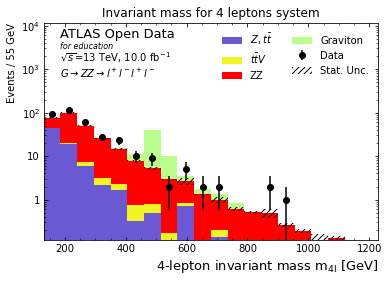

In [15]:
plot_data(data)

In [16]:
print(data)

{'data':                                           lep_pt  \
0    [175558.73, 138846.67, 106696.53, 79776.73]   
1    [65284.066, 37290.766, 12426.926, 8804.564]   
2     [146784.7, 127539.97, 33562.18, 29776.129]   
3     [135680.69, 82894.8, 62508.098, 42552.906]   
4    [67713.18, 42791.816, 12742.542, 10291.093]   
..                                           ...   
502  [51773.375, 51708.45, 51148.297, 30737.582]   
503  [61561.816, 25231.277, 21982.31, 14411.031]   
504  [53048.145, 39838.145, 23835.697, 7428.501]   
505   [114072.234, 113360.6, 64472.6, 26180.354]   
506   [88545.625, 50751.836, 25529.92, 22951.45]   

                                               lep_eta  \
0          [2.076854, 0.9641987, 0.4538123, 2.3985784]   
1     [0.103151694, 0.43131045, 0.98646265, 1.1151001]   
2    [-0.20137234, -0.26222968, -0.2997417, 0.47760...   
3        [1.4913375, 0.73802865, 1.2436671, 0.5755266]   
4    [-1.5264179, -0.06150811, -0.6896634, -0.6163658]   
..                

## Optimisation

Here we define histograms for the variables that we'll look to optimise

In [17]:
mllll = { # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    'bin_width':5, # width of each histogram bin
    'num_bins':20, # number of histogram bins
    'xrange_min':130, # minimum on x-axis
    'xlabel':r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]', # x-axis label
}

lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}

SoverB_hist_dict = {'mllll':mllll, 'lep_pt_1':lep_pt_1} 
# add a histogram here if you want it plotted

Here we define a function to illustrate the optimum cut value on individual variables, based on signal to background ratio.

In [18]:
def plot_SoverB(data):
    
    signal = 'Graviton' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries

    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.93, # y
                 'ATLAS Open Data', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.88, # y
                 'for education', # text
                 transform=distributions_axes.transAxes, # coordinate system used is that of distributions_axes
                 style='italic',
                 fontsize=8 )  
        plt.savefig('plots/Graviton_BDT/Graviton-'+x_variable+'-distribution.pdf')
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        plt.savefig('plots/Graviton_BDT/Graviton-'+x_variable+'-SoverB.pdf')
        plt.show() # show S/B plot
    
    return

Here we call our function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

We're not doing any Machine Learning yet! We're looking at the variables we'll later use for Machine Learning.

Let's talk through the lep_pt_2 plots.
1. Imagine placing a cut at 7 GeV in the distributions of <span style="color:blue">signal</span> and <span style="color:red">background</span> (1st plot). This means keeping all events above 7 GeV in the <span style="color:blue">signal</span> and <span style="color:red">background</span> histograms. 
2. We then take the ratio of the number of <span style="color:blue">signal</span> events that pass this cut, to the number of <span style="color:red">background</span> events that pass this cut. This gives us a starting value for S/B (2nd plot). 
3. We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more <span style="color:red">background</span> than <span style="color:blue">signal</span>, so S/B increases. 
4. There comes a point around 13 GeV where we start throwing away too much <span style="color:blue">signal</span>, thus S/B starts to decrease. 
5. Our goal is to find the maximum in S/B, and place the cut there.

The same logic applies to lep_pt_1.

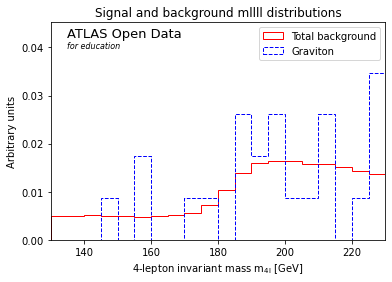

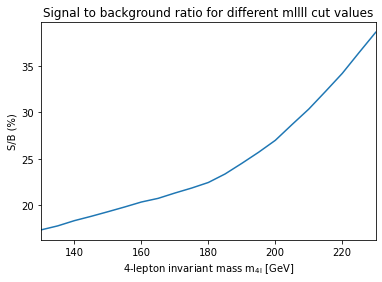

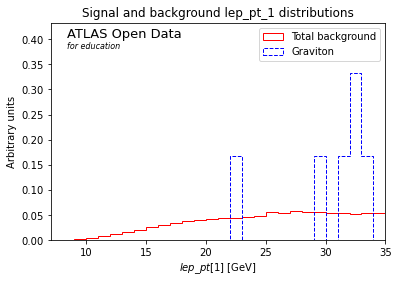

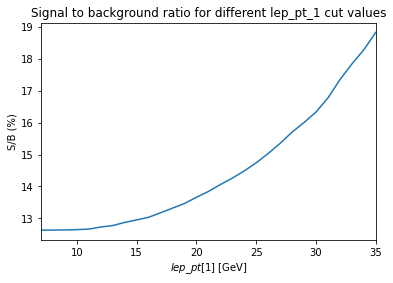

In [19]:
plot_SoverB(data)

## Boosted Decision Tree (BDT)

Choose variables for use in the BDT

In [20]:
data_for_BDT = {} # define empty dictionary to hold dataframes that will be used to train the BDT
BDT_inputs = ['mllll', 'lep_pt_1'] # list of features for BDT
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_BDT[key] = data[key][BDT_inputs].copy()
data_for_BDT

{'data':           mllll    lep_pt_1
 0    649.271931  138.846672
 1     87.907098   37.290766
 2    344.775936  127.539969
 3    326.583790   82.894797
 4    107.422585   42.791816
 ..          ...         ...
 502  209.585334   51.708449
 503  121.270402   25.231277
 504  149.033446   39.838145
 505  318.595413  113.360602
 506  305.914725   50.751836
 
 [507 rows x 2 columns],
 '$Z,t\\bar{t}$':           mllll   lep_pt_1
 0    123.778564  37.666000
 1    162.560351  43.458098
 2    219.564061  30.980805
 3    157.108745  17.793098
 4    106.592748  32.687891
 ..          ...        ...
 829  221.392648  71.749195
 830   89.324171  15.723056
 831  271.143367  81.012563
 832  251.470387  54.549004
 833  191.160258  44.278621
 
 [834 rows x 2 columns],
 '$t\\bar{t}V$':             mllll    lep_pt_1
 0      327.971895   45.836844
 1      284.315799   60.211449
 2      164.165964   39.748355
 3      348.362722   77.523062
 4      253.838232   50.922887
 ...           ...         ...
 250

 Organise data ready for the BDT

In [21]:
# for sklearn data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_BDT[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='Graviton' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_BDT[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_BDT['Graviton'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

### The Training and Testing split
One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of <span style="color:orange">X</span> for training and the last 33% for testing. This is particularly important in cases where you load all <span style="color:blue">signal</span> events first and then the <span style="color:red">background</span> events.

Here we split our data into two independent samples. The split is to create a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

We don't want to test on events that we used to train on, this prevents overfitting to some subset of data so the network would be good for the test data but much worse at any *new* data it sees.

In [22]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=492 )

### Training Decision Trees
We'll use SciKit Learn (sklearn) in this tutorial. Other possible tools include keras and pytorch. 

Here we set several hyper-parameters to non default values.

After instantiating our <span style="color:orange">AdaBoostClassifier</span>, call the <span style="color:orange">fit()</span> method with the training sample as an argument. This will train the tree, now we are ready to evaluate the performance on the held out testing set.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train, y_train) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

Time taken to fit BDT: 3.3s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)


### Assessing a Classifier's Performance
Next let's create a quick report on how well our classifier is doing. It is important to make sure you use samples not seen by the classifier to get an unbiased estimate of its performance.

In [24]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score

y_predicted = bdt.predict(X_test) # get predicted y for test set
#sklearn.metrics.f1_score(y_test, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
#f1_score(y_test, y_predicted, zero_division=1)
        
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    bdt.decision_function(X_test))) )
y_predicted

              precision    recall  f1-score   support

  background       0.99      0.99      0.99    274855
      signal       0.45      0.52      0.48      3093

    accuracy                           0.99    277948
   macro avg       0.72      0.76      0.74    277948
weighted avg       0.99      0.99      0.99    277948

Area under ROC curve for test data: 0.9735


array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
y_predicted = bdt.predict(X_train) # get predicted y for train set
print (classification_report(y_train, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for training data: %.4f"%(roc_auc_score(y_train,
                                                    bdt.decision_function(X_train))))

              precision    recall  f1-score   support

  background       1.00      0.99      0.99    275038
      signal       0.45      0.54      0.49      2909

    accuracy                           0.99    277947
   macro avg       0.72      0.77      0.74    277947
weighted avg       0.99      0.99      0.99    277947

Area under ROC curve for training data: 0.9755


### Receiver Operarting Characteristic (ROC) curve for BDT
Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

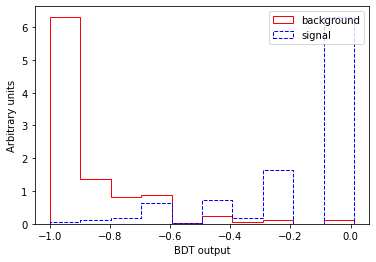

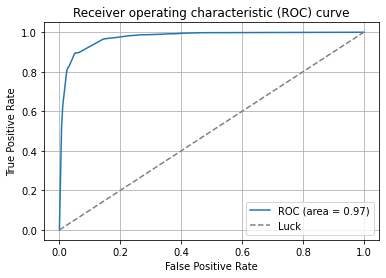

In [26]:
# we first plot the Neural Network output
signal_decisions = bdt.decision_function(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = bdt.decision_function(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('BDT output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test).ravel() # get probabilities on test set

# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_test, # actual
                        decisions ) # predicted

# Compute area under the curve for training set
roc_auc = auc(fpr, # false positive rate 
              tpr) # true positive rate

plt.plot(fpr, tpr, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve') # title
plt.legend() # add legend
plt.grid() # add grid
plt.savefig('plots/Graviton_BDT/Graviton-ROC-curve.pdf')

### BDT Overtraining Check
Comparing the BDT's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The <span style="color:orange">compare_train_test()</span> method will plot the shape of the BDT's decision function for each class, as well as overlaying it with the decision function in the training set.

There are techniques to prevent overtraining.

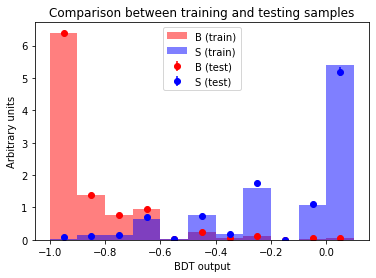

In [27]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.decision_function(X[y<0.5]).ravel() # background
        d2 = clf.decision_function(X[y>0.5]).ravel() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -1.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("BDT output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.title("Comparison between training and testing samples")
    plt.legend() # add legend
    plt.savefig('plots/Graviton_BDT/Graviton-BDT-comparison.pdf')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test) # call compare_train_test

### BDT Optimisation

Here we get the BDT's decision function for every event that was processed at the begininning (so could be data, <span style="color:blue">signal</span>, <span style="color:red">background</span>...). The higher the decision function, the more the BDT thinks that event looks like <span style="color:blue">signal</span>.

In [28]:
# X only has only the MC features
y_predicted = bdt.decision_function(X) 
y_predicted

array([-1.        , -1.        , -1.        , ..., -0.06239956,
        0.01182942, -0.62368954])

In [29]:
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in data: # loop over samples
    if(key != 'data'):
        data[key]['BDT_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
        cumulative_events += len(data[key]) # increment counter for total number of events
        print(data[key]['BDT_output']) # print the dataframe column BDT_output

0     -1.000000
1     -1.000000
2     -1.000000
3     -1.000000
4     -1.000000
         ...   
829   -0.952557
830   -1.000000
831   -0.709948
832   -0.964440
833   -1.000000
Name: BDT_output, Length: 834, dtype: float64
0       -0.839513
1       -0.890211
2       -1.000000
3       -0.623690
4       -0.964440
           ...   
25097   -0.623690
25098   -0.623690
25099   -1.000000
25100   -1.000000
25101   -0.623690
Name: BDT_output, Length: 25102, dtype: float64
0        -1.000000
1        -1.000000
2        -0.709948
3        -1.000000
4        -0.697919
            ...   
523952   -0.890211
523953   -0.964440
523954   -0.623690
523955   -1.000000
523956   -1.000000
Name: BDT_output, Length: 523957, dtype: float64
0      -0.247122
1       0.011829
2       0.011829
3      -0.062400
4       0.011829
          ...   
5997    0.011829
5998   -0.438967
5999   -0.062400
6000    0.011829
6001   -0.623690
Name: BDT_output, Length: 6002, dtype: float64


In [30]:
bin_width = 0.1
max_BDT = y_predicted.max()+bin_width
min_BDT = y_predicted.min()-bin_width
num_bins = np.ceil((max_BDT - min_BDT)/bin_width)
num_bins = num_bins.astype(int)
print("The max and min value of the BDT output for the y_predicted is {:.2f} and {:.2f}, {:.2f} respectively".format(
    max_BDT, min_BDT, num_bins))

The max and min value of the BDT output for the y_predicted is 0.11 and -1.10, 13.00 respectively


In [31]:
BDT_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':bin_width, # width of each histogram bin
    'num_bins':num_bins, # number of histogram bins
    'xrange_min':min_BDT, # minimum on x-axis
    'xlabel':'BDT output', # x-axis label
}

SoverB_hist_dict = {'BDT_output':BDT_output}

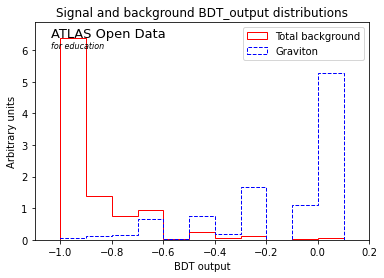

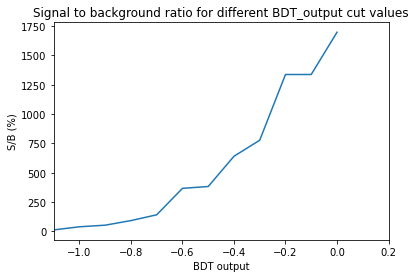

In [32]:
plot_SoverB(data)

In [33]:
data_BDT = {}
data_BDT = data.copy()
del data_BDT['data']

In [34]:
for key in data_BDT: # loop over samples
    if key!='data':
        fail_BDT_ouput = data_BDT[key][data_BDT[key]['BDT_output'] <= -0.6].index
        data_BDT[key].drop(fail_BDT_ouput,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
        data_BDT[key] = data_BDT[key].reset_index(drop=True)

In [35]:
def plot_data_opt(data):

    xmin = 130 # GeV
    xmax = 1230 # GeV
    step_size = 55 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    signal_x = data['Graviton']['mllll'] # histogram the signal
    signal_weights = data['Graviton'].totalWeight # get the weights of the signal events
    signal_color = samples['Graviton']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', 'Graviton']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
        
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label='Graviton')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    main_axes.set_yscale('log') # set y-scale
    smallest_contribution = mc_heights[0][0] # get smallest contribution
    smallest_contribution.sort() # sort smallest contribution
    bottom = 0.1 # set bottom limit on y-axis
    top = 1000 # set top limit on y-axis
    main_axes.set_ylim( bottom=bottom, top=top ) # y-axis limits
    main_axes.yaxis.set_major_formatter( CustomTicker() ) 
    locmin = LogLocator(base=10.0, # log base 10
                        subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) ) # minor tick every 0.1 
    main_axes.yaxis.set_minor_locator( locmin ) # set minor ticks

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(round(lumi*fraction,2)) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.75, # y
             r'$G \rightarrow ZZ \rightarrow l^+l^-l^+l^-$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(ncol=2, # 2 columns
                     frameon=False ) # no box around the legend
    plt.title("Invariant mass for 4 leptons system")
    plt.savefig('plots/Graviton_BDT/Graviton-invariant-mass-optimized.pdf')
    
    return

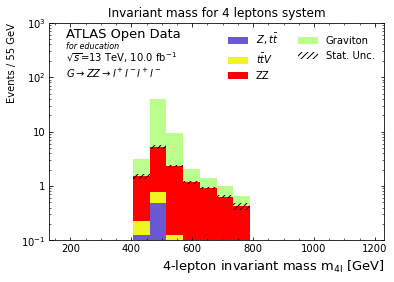

In [36]:
plot_data_opt(data_BDT)